### Phase1: Collecting Required Package and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score


In [2]:
data = pd.read_csv("C:/Users/Mohan/Documents/___.__/Project/USDINR.csv")

### Phase2: Preprocessing

In [3]:
data['Date'] = pd.to_datetime(data["Date"], format='%d/%m/%Y %H:%M:%S')
# data= data.set_index(["Date"], drop=False)

In [4]:
data['Date']=data.Date.apply(lambda x: str(x).split(" ")[0])

In [5]:
data['Date'] = pd.to_datetime(data['Date'])

<AxesSubplot: >

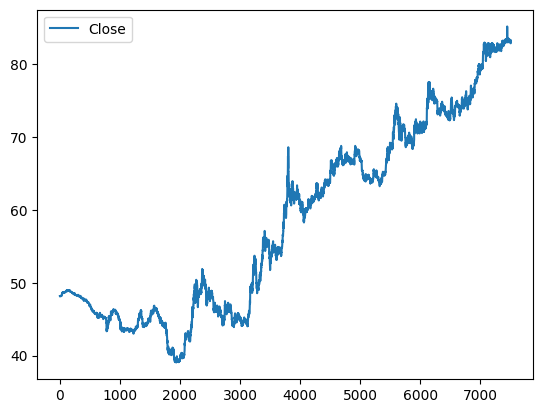

In [6]:
data.plot(y='Close')

In [7]:
data['Date'].sort_values()

0      2002-01-01
1      2002-01-02
2      2002-01-03
3      2002-01-04
4      2002-01-05
          ...    
7506   2023-12-27
7507   2023-12-28
7508   2023-12-29
7509   2023-12-30
7510   2023-12-31
Name: Date, Length: 7511, dtype: datetime64[ns]

In [8]:
data.head()

,Date,Close
0,2002-01-01,48.165
1,2002-01-02,48.171
2,2002-01-03,48.169
3,2002-01-04,48.166
4,2002-01-05,48.180


In [9]:
data.tail()

,Date,Close
7506,2023-12-27,83.26745
7507,2023-12-28,82.89100
7508,2023-12-29,83.24885
7509,2023-12-30,83.24885
7510,2023-12-31,83.24885


In [10]:
data.describe()

,Close
count,7511.000000
mean,58.476561
std,13.007357
min,39.045000
25%,45.949500
50%,59.168000
75%,69.524250
max,85.201500


In [11]:
split_date = pd.Timestamp('01-01-2019')

test = data[data['Date']>=split_date]
train = data[data['Date']<split_date]
print(len(train),len(test))


5685 1826


In [12]:
train=train.drop(['Date'],axis=1)
test=test.drop(['Date'],axis=1)

In [13]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train = sc.fit_transform(train)
test = sc.transform(test)

In [14]:
train=pd.DataFrame(train)
test=pd.DataFrame(test)

In [15]:
train

,0
0,0.256504
1,0.256673
2,0.256617
3,0.256532
4,0.256926
...,...
5680,0.870342
5681,0.866404
5682,0.860357
5683,0.868443


### Phase3: LSTM layer

In [16]:
# Define and train LSTM model
def create_lstm_model(input_shape):
    look_back = 10
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))  # Hyperparameter: Number of LSTM units
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def train_lstm_model(train_data):
    X_train, y_train = [], []
    for i in range(len(train_data)-11):
        X_train.append(train_data.iloc[i:i+10])
        y_train.append(train_data.iloc[i+11])
    X_train, y_train = np.array(X_train), np.array(y_train)
    print(X_train.shape,y_train.shape)
    model = create_lstm_model(X_train.shape[1:])
    model.summary()
    model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=0)
    
    return model

lstm_model = train_lstm_model(train)




(5674, 10, 1) (5674, 1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



In [17]:
# Make predictions using LSTM model
def lstm_forecast(model, test_data):
    X_test, y_test = [], []
    for i in range(len(test_data)-11):
        X_test.append(test_data.iloc[i:i+10])
        y_test.append(test_data.iloc[i+11])
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    y_pred = model.predict(X_test, verbose=0)
    return y_pred, y_test

lstm_predictions, y_test = lstm_forecast(lstm_model,test)

In [18]:
lstm_predictions

array([[0.8865721 ],
       [0.8798558 ],
       [0.88109225],
       ...,
       [1.1864378 ],
       [1.1797426 ],
       [1.1868142 ]], dtype=float32)

In [19]:
y_test

array([[0.88102939],
       [0.88102939],
       [0.90113908],
       ...,
       [1.24325271],
       [1.24325271],
       [1.24325271]])

### Phase4: ARIMA layer

In [20]:
# Calculate residuals (difference between actual values and LSTM predictions)
residuals = y_test - lstm_predictions

# Train ARIMA model on residuals
arima_model = ARIMA(residuals, order=(5,1,0))
arima_model_fit = arima_model.fit()

# Make predictions using ARIMA modeL
arima_predictions = arima_model_fit.forecast(steps=len(y_test))
arima_predictions=arima_predictions.reshape(-1,1)
# Combine forecasts from LSTM and ARIMA
hybrid_forecast = lstm_predictions + arima_predictions

In [21]:
lstm_predictions.shape

(1815, 1)

In [22]:
arima_predictions.shape

(1815, 1)

In [23]:
hybrid_forecast.shape

(1815, 1)

In [24]:
mae_lstm = mean_absolute_error(lstm_predictions,y_test)
mae_arima =mean_absolute_error(arima_predictions, y_test)
mae_hybrid =mean_absolute_error(hybrid_forecast,y_test)
mse_lstm = mean_squared_error(lstm_predictions,y_test)
mse_arima =mean_squared_error(arima_predictions, y_test)
mse_hybrid =mean_squared_error(hybrid_forecast,y_test)
rmse_lstm = np.sqrt(mean_squared_error(lstm_predictions,y_test))
rmse_arima =np.sqrt(mean_squared_error(arima_predictions, y_test))
rmse_hybrid =np.sqrt(mean_squared_error(hybrid_forecast,y_test))
r2_lstm = r2_score(lstm_predictions,y_test)
r2_arima =r2_score(arima_predictions, y_test)
r2_hybrid =r2_score(hybrid_forecast,y_test)

### Phase5: Results and Conclusions

Mean Absolute Error (LSTM)  : 0.02277481369515258
Mean Absolute Error (ARIMA)    : 0.9820044336671324
Mean Absolute Error (Hybrid): 0.03632688408544797

Mean Squared Error (LSTM)  : 0.0009051199148986137
Mean Squared Error (ARIMA)    : 0.980087979098805
Mean Squared Error (Hybrid): 0.0017302654291862824

Root Mean Squared Error (LSTM)  : 0.030085210900018863
Root Mean Squared Error (ARIMA)    : 0.9899939288191645
Root Mean Squared Error (Hybrid): 0.04159645933473524

r2_score (LSTM)  : 0.920277351209932
r2_score (ARIMA)    : -403500313.3919604
r2_score (Hybrid): 0.8476013022405243


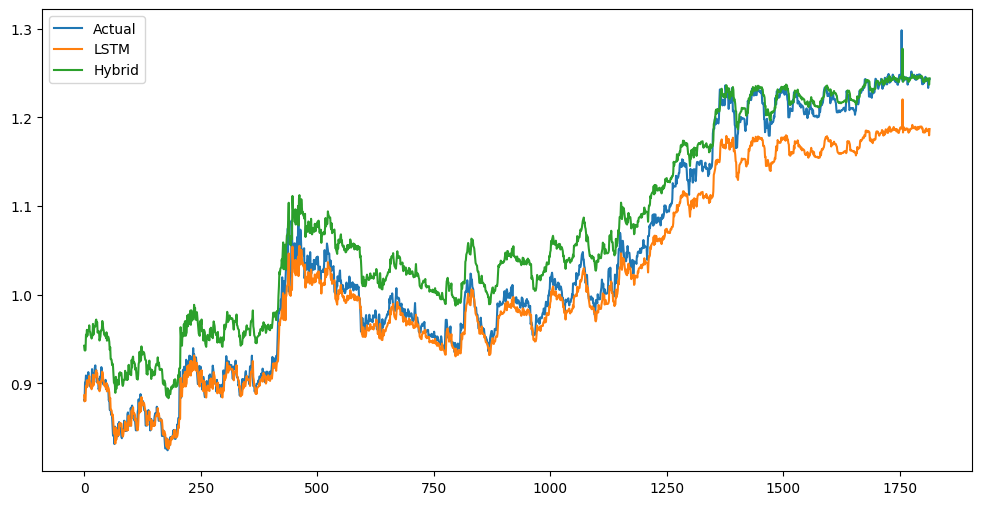

In [25]:
print("Mean Absolute Error (LSTM)  :", mae_lstm)
print("Mean Absolute Error (ARIMA)    :", mae_arima)
print("Mean Absolute Error (Hybrid):", mae_hybrid)
print("")
print("Mean Squared Error (LSTM)  :", mse_lstm)
print("Mean Squared Error (ARIMA)    :", mse_arima)
print("Mean Squared Error (Hybrid):", mse_hybrid)
print("")
print("Root Mean Squared Error (LSTM)  :", rmse_lstm)
print("Root Mean Squared Error (ARIMA)    :", rmse_arima)
print("Root Mean Squared Error (Hybrid):", rmse_hybrid)
print("")
print("r2_score (LSTM)  :", r2_lstm)
print("r2_score (ARIMA)    :", r2_arima)
print("r2_score (Hybrid):", r2_hybrid)

# Plot forecasts
plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual')
plt.plot(lstm_predictions, label='LSTM')
#plt.plot(arima_predictions, label='ARIMA')
plt.plot(hybrid_forecast, label='Hybrid')
plt.legend()
plt.show()

In [26]:
final_predictions=np.array(hybrid_forecast)
final_predictions=pd.DataFrame(final_predictions)
final_predictions.to_csv('LSTIM_ARIMA_USDINR.csv', index=False)